## Import ##
HDF5Matrix 를 사용하기 위하 tensorflow ,버전을 확인한다  tensorflow 버전이 2.3.1 이 아닌경우는  !pip install tensorflow==2.3.1 로 버전을 2.3.1로 조정한다.

In [1]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import HDF5Matrix
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
from functools import partial
from tensorflow.keras import layers

## 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## google drive mount 및 data load 처리 ##

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
def load_data():
    try:
        y_train = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_train_y.h5' , 'y')
        x_valid = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_valid_x.h5', 'x')
        y_valid = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_valid_y.h5', 'y')
        x_test  = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_test_x.h5', 'x')
        y_test  = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_test_y.h5', 'y')
        x_train = HDF5Matrix('/content/gdrive/My Drive/Colab Notebooks/h5/camelyonpatch_level_2_split_train_x.h5', 'x')
    except OSError:
        raise NotImplementedError('Direct download currently not working. Please go to https://drive.google.com/drive/folders/1gHou49cA1s5vua2V5L98Lt8TiWA3FrKB and press download all. Then place files (ungzipped) in ~/.keras/datasets/pcam.')
        
    if K.image_data_format() == 'channels_first':
        raise NotImplementedError()

    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)


if __name__ == '__main__':
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_data()
    print(len(x_train))

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.
262144


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/io_utils.py:133: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


## 하이퍼파라미터 및 기본값 세팅


In [5]:
train_size  = 30000
test_size   = 15000
valid_size  = 15000
input_shape = (96, 96, 3)  # 이미지 데이터 1장의 크기s
num_classes = 2           # 분류하고자 하는 범주의 개수
EPOCHS      = 10
class_names = ['Positive','Negative']

## 데이터 전처리

In [6]:
## 이미지 데이터의 값 범위를 [0, 255]에서 [0, 1]로 변경하기

X_train = x_train[:train_size] / 255.0
X_test  = x_test[:test_size] / 255.0
X_valid = x_valid[:valid_size] / 255.0
y_train = y_train[:train_size]
y_test  = y_test[:test_size]
y_valid = y_valid[:valid_size]

y_train = y_train[:,0,0,0]
y_test  = y_test[:,0,0,0]
y_valid = y_valid[:,0,0,0]

In [7]:
## shape 확인
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(30000, 96, 96, 3)
(15000, 96, 96, 3)
(15000, 96, 96, 3)
(30000,)
(15000,)
(15000,)


In [8]:
## tensorflow 학습을 위해 float32 형으로 형변환 한다.
X_train  = X_train[:,:,:,:].astype(np.float32)
X_test   = X_test[:,:,:,:].astype(np.float32)
X_valid  = X_valid[:,:,:,:].astype(np.float32)

## 모델정의

In [9]:
inputs = layers.Input(input_shape)

# CNN Layers
net = layers.Conv2D(16, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(16, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)

net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)

# Flattening CNN output
net = layers.Flatten()(net)
net = layers.Dense(2048)(net)
net = layers.Activation('relu')(net)

net = layers.Dense(num_classes)(net)

net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [19]:
## Keras 모델 살펴보기
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        46

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 학습 루프 동작

In [11]:
%%time
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_data=(X_valid, y_valid))

Epoch 1/10
235/235 [==============================] - 8s 36ms/step - loss: 0.5207 - accuracy: 0.7396 - val_loss: 0.4442 - val_accuracy: 0.8013
Epoch 2/10
235/235 [==============================] - 8s 34ms/step - loss: 0.4353 - accuracy: 0.8032 - val_loss: 0.4503 - val_accuracy: 0.8077
Epoch 3/10
235/235 [==============================] - 8s 34ms/step - loss: 0.4057 - accuracy: 0.8232 - val_loss: 0.4432 - val_accuracy: 0.8170
Epoch 4/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3732 - accuracy: 0.8377 - val_loss: 0.4021 - val_accuracy: 0.8251
Epoch 5/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3547 - accuracy: 0.8446 - val_loss: 0.4467 - val_accuracy: 0.8043
Epoch 6/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3305 - accuracy: 0.8577 - val_loss: 0.3512 - val_accuracy: 0.8463
Epoch 7/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3049 - accuracy: 0.8713 - val_loss: 0.3842 - val_accuracy: 0.8311

## Accuracy , Loss 확인 및 시각화

In [12]:
history_df = pd.DataFrame(history.history, index=history.epoch)
history_df.head(10)

,loss,accuracy,val_loss,val_accuracy
0,0.520715,0.739600,0.444164,0.801267
1,0.435268,0.803167,0.450302,0.807733
2,0.405671,0.823167,0.443195,0.817000
3,0.373246,0.837667,0.402055,0.825067
4,0.354692,0.844633,0.446717,0.804333
5,0.330536,0.857667,0.351190,0.846267
6,0.304942,0.871333,0.384211,0.831067
7,0.282755,0.881867,0.347144,0.846333
8,0.259525,0.892400,0.351795,0.850733
9,0.240149,0.901300,0.393631,0.826933


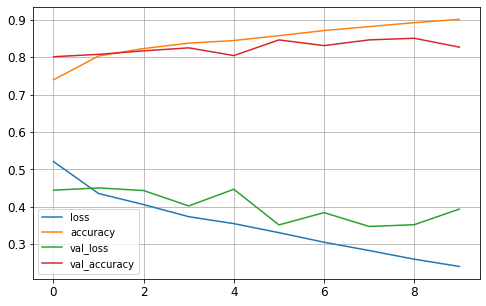

In [13]:
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## Test set 을 통한 최종 모델 평가

In [14]:
score = model.evaluate(X_test, y_test)
print(score)

469/469 [==============================] - 2s 4ms/step - loss: 0.4219 - accuracy: 0.8169
[0.42186304926872253, 0.8169333338737488]


## Confusion Matrix 확인

In [15]:
y_test_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)

In [16]:
## Confusion matrix 

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df

,Positive,Negative
Positive,6797,665
Negative,2081,5457


In [17]:
  ## Classification report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=class_names))

              precision    recall  f1-score   support

    Positive       0.77      0.91      0.83      7462
    Negative       0.89      0.72      0.80      7538

    accuracy                           0.82     15000
   macro avg       0.83      0.82      0.82     15000
weighted avg       0.83      0.82      0.82     15000

